<a href="https://colab.research.google.com/github/SRI-CSL/CoProver/blob/main/src/notebooks/220325_t5/220413_coprover_simplet5_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoProver `Simple T5`-transformer experiments

##### **Copyright 2022 SRI International.**

# 🏃‍♀️ Quickstart

In this notebook, we make use of T5 transformer models for **Next Command Prediction** task.

## &#9776; Import libraries

In [1]:
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
try:
  from simplet5 import SimpleT5
except ImportError:
  !pip install --upgrade simplet5

Global seed set to 42


In [67]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from tqdm import tqdm

## &#9881; Define `needed` functions

In [41]:
def score_df(input_model, input_df):
  """a slight modification to EY-method ensuring that we retrieve all 
  the necessary output for the confusion matrix construction as np.array

  Note: Trained input_model should be loaded before executing this method
  """

  num_correct = 0
  total = 0
  pred_labels = []
  true_labels = []

  for idx, row in tqdm(input_df.iterrows(), total=len(input_df)):
    # predicted label
    p_label = input_model.predict(row.source_text)[0]

    # true label
    t_label = row.target_text

    pred_labels.append(p_label)
    true_labels.append(t_label)

    total += 1

    if p_label == t_label:
      num_correct += 1

  return num_correct, total, pred_labels, true_labels

# &#129529; Data cleaning and preparation

In [3]:
proof_file = 'tags_input_pred_pairs.tsv'

In [4]:
if not os.path.exists(proof_file):
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1J9xAcdlo8NXRlbz3SQh_GvbVsk90a4jK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1J9xAcdlo8NXRlbz3SQh_GvbVsk90a4jK" -O 'tags_input_pred_pairs.tsv' && rm -rf /tmp/cookies.txt
else:
  print(f"{proof_file} already exists!")

--2022-04-15 14:01:25--  https://docs.google.com/uc?export=download&confirm=&id=1J9xAcdlo8NXRlbz3SQh_GvbVsk90a4jK
Resolving docs.google.com (docs.google.com)... 64.233.166.139, 64.233.166.100, 64.233.166.138, ...
Connecting to docs.google.com (docs.google.com)|64.233.166.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0sf63h1ee3vg14ktiu2jiu0recdaaujr/1650031275000/12981205944103091625/*/1J9xAcdlo8NXRlbz3SQh_GvbVsk90a4jK?e=download [following]
--2022-04-15 14:01:26--  https://doc-08-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0sf63h1ee3vg14ktiu2jiu0recdaaujr/1650031275000/12981205944103091625/*/1J9xAcdlo8NXRlbz3SQh_GvbVsk90a4jK?e=download
Resolving doc-08-a4-docs.googleusercontent.com (doc-08-a4-docs.googleusercontent.com)... 142.251.5.132, 2a00:1450:400c:c1b::84
Connecting to doc-08-a4-docs.googleusercontent.com (doc-08-a4-d

In [5]:
# df = pd.read_csv(path)
full_df = pd.read_csv(f'./{proof_file}', sep="\t", header=None, names=['source_text', 'target_text'])

In [6]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16065 entries, 0 to 16064
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  16065 non-null  object
 1   target_text  16065 non-null  object
dtypes: object(2)
memory usage: 251.1+ KB


In [7]:
full_df.head()

,source_text,target_text
0,<ANT> <CONS> s-formula forall ['variable'] ['v...,subtype-tcc
1,<ANT> <CONS> s-formula forall ['variable'] ['v...,skosimp*
2,<ANT> <CONS> s-formula apply constant type-act...,apply-extensionality
3,<ANT> <CONS> s-formula apply constant type-act...,grind
4,<ANT> <CONS> s-formula forall ['variable'] ['v...,subtype-tcc


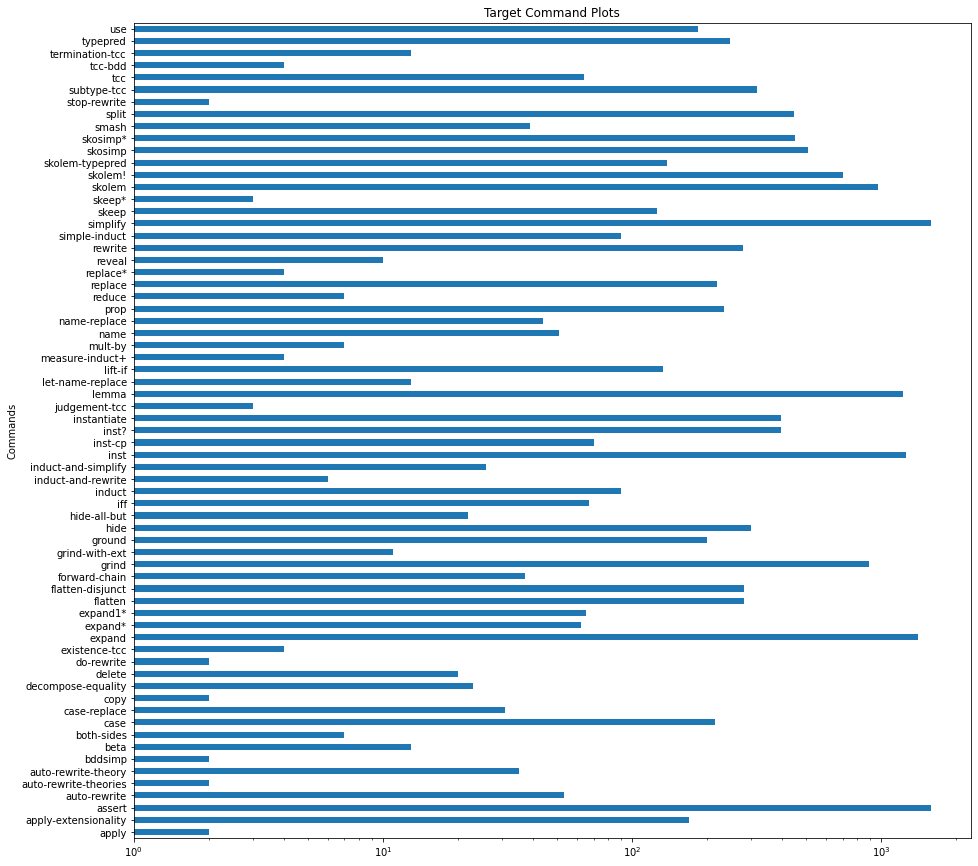

In [8]:
tmp_target = full_df.groupby(full_df.target_text).size()
tmp_target.plot.barh(title="Target Command Plots", xlabel="Commands", ylabel="Number of records", log=True, figsize=(15, 15))

In [9]:
# Command prefixes are always expected
CMD1_PREFIX = "command1: "

In [10]:
full_df['source_text'] = CMD1_PREFIX + full_df['source_text']

In [11]:
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=1337, shuffle=True)

# &#129504; `simpleT5`

## &#128722; T5 Model Load

In [14]:
model = SimpleT5()

In [15]:
model.from_pretrained(model_type="t5", model_name="t5-base")

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

## &#128640; Hyperparameter setup

In [13]:
SOURCE_MAX_TOKEN_LEN = max([len(x.split()) for x in full_df['source_text']]) + 10
TARGET_MAX_TOKEN_LEN = 10
BATCH_SIZE = 4
MAX_EPOCH = 3
DATALOADER_NUM_WORKERS = 4
SAVE_ONLY_LAST_EPOCH = True
USE_GPU = True
NUM_GPUS = 1

## &#9203; Training

In [16]:
model.train(train_df=train_df,
            eval_df=test_df, 
            source_max_token_len=SOURCE_MAX_TOKEN_LEN, 
            target_max_token_len=TARGET_MAX_TOKEN_LEN, 
            batch_size=BATCH_SIZE, 
            max_epochs=MAX_EPOCH, 
            use_gpu=USE_GPU)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## &#129514; Testing

In [29]:
# Load the trained model
trained_model_path = './outputs/simplet5-epoch-2-train-loss-0.718-val-loss-0.6536'
model.load_model("t5", trained_model_path, use_gpu=False)

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 9636 to 11090
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  3213 non-null   object
 1   target_text  3213 non-null   object
dtypes: object(2)
memory usage: 75.3+ KB


In [21]:
test_df.describe()

,source_text,target_text
count,3213,3213
unique,2607,53
top,command1: <ANT> s-formula apply constant foral...,simplify
freq,26,299


In [22]:
test_df.head()

,source_text,target_text
9636,command1: <ANT> s-formula apply constant apply...,simplify
2759,command1: <ANT> s-formula apply constant apply...,case
15379,command1: <ANT> s-formula apply constant apply...,assert
12708,command1: <ANT> s-formula apply constant apply...,simplify
8092,command1: <ANT> s-formula apply constant foral...,hide


In [53]:
# return num_correct, total, pred_labels, true_labels
correct_preds, total_samples, pred_labels_lst, true_labels_lst = score_df(input_model=model, input_df=test_df)

100%|██████████| 3213/3213 [1:21:44<00:00,  1.53s/it]


In [54]:
print(f"{correct_preds} samples were predicted CORRECTLY out of {total_samples} samples present in the input DataFrame.\tAccuracy: {correct_preds/total_samples:.3f}")

901 samples were predicted CORRECTLY out of 3213 samples present in the input DataFrame.	Accuracy: 0.280


In [56]:
p_np = np.array(pred_labels_lst)
t_np = np.array(true_labels_lst) 

In [68]:
cf_matrix = confusion_matrix(p_np, t_np)
print(cf_matrix)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 0]]


In [62]:
accuracy = round(accuracy_score(t_np, p_np), 3)
print(accuracy)

precision = round(precision_score(t_np, p_np, average='micro'), 3)
print(precision)

recall = round(recall_score(t_np, p_np, average='micro'), 3)
print(recall)

0.28
0.28
0.28


In [65]:
classification = classification_report(t_np, p_np)
print(classification)

                      precision    recall  f1-score   support

apply-extensionality       0.00      0.00      0.00        25
              assert       0.33      0.00      0.01       294
        auto-rewrite       0.00      0.00      0.00         8
 auto-rewrite-theory       0.00      0.00      0.00         4
                beta       0.00      0.00      0.00         7
                case       0.00      0.00      0.00        45
        case-replace       0.00      0.00      0.00         6
  decompose-equality       0.00      0.00      0.00         2
              delete       0.00      0.00      0.00         3
              expand       0.40      0.34      0.37       286
             expand*       0.00      0.00      0.00        11
            expand1*       0.00      0.00      0.00        15
             flatten       0.16      0.49      0.25        63
    flatten-disjunct       0.00      0.00      0.00        64
       forward-chain       0.00      0.00      0.00         7
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### &#127939; Sample runs

In [70]:
input_sequence = "<ANT> <CONS> s-formula forall ['variable'] ['variable'] apply constant type-actual apply constant type-actual type-actual apply constant ['variable'] ['variable'] apply constant apply constant type-actual type-actual ['variable'] apply constant type-actual type-actual ['variable'] <HID>"

print(model.predict(CMD1_PREFIX + input_sequence)[0])

skolem


In [1]:
def show_sample_outputs(trained_model, input_df):

  for idx, row in input_df.iterrows():
    input_sequence = row.source_text
    y_true = row.target_text
    y_pred = trained_model.predict(input_sequence)[0]

    print(f"- Input sequence: {input_sequence}\n- Expected command: {y_true}\n- Predicted command: {y_pred}\n-------")

In [74]:
show_sample_outputs(trained_model=model, input_df=train_df.head(10))

- Input sequence: command1: <ANT> s-formula apply constant forall ['variable'] apply constant apply constant ['variable'] constant apply constant apply constant ['variable'] formal-constant apply constant ['variable'] s-formula apply constant apply constant constant formal-constant s-formula apply constant apply constant constant constant <CONS> s-formula apply constant constant s-formula apply constant constant s-formula apply constant constant <HID> s-formula apply constant forall ['variable'] apply constant forall ['variable'] apply constant apply constant ['variable'] ['variable'] apply constant ['variable'] apply constant ['variable'] s-formula apply constant forall ['variable'] apply constant forall ['variable'] apply constant forall ['variable'] apply constant apply constant ['variable'] ['variable'] apply ['variable'] ['variable'] apply ['variable'] ['variable'] forall ['variable'] apply ['variable'] ['variable']
- Expected command: inst
- Predicted command: inst
-------
- Inpu